In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import sys
from scipy.interpolate import interp1d
from scipy import interpolate
from numba import autojit
import numdifftools as nd
import numdifftools.nd_algopy as nda
from pylab import *
from matplotlib import gridspec
import netCDF4
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
sys.path.append('/noc/users/hb1g13/Python/python_functions/')
from useful import *
from Flat_channel import *
from HB_Plot import nf, fmt
import SG as SG
import layers_calc_numba
sys.path.append('/noc/users/hb1g13/Python/python_functions/MITgcmUtils/')
import utils
%matplotlib inline

In [3]:
# Some parameters
Full = 'Extremes'  # 9 Pannels isn't ideal for presentations N option give 4 plots
Qplot = 'Y'
Figletter = ['a) ','b) ','c) ','d) ','e)','f)','g)','h)','j)']
# Path root
x = '/noc/msm/scratch/students/hb1g13/Mobilis/instantaneous'
# Now Make file structure
tau = ['3day_full', 'Closedday_full', '3day', 'Closedday']
check = 0
runs = []
for i in range(len(tau)):
    flist = x+'/'+str(tau[i])+'/Tav.nc'
    if not os.path.exists(flist):
        print ' WARNING: '+flist+' does not exist! (skipping this tau...)'
        check += 0
    else:
        check += 1
        runs.append(i)
Runs=np.array(runs)

/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in greater


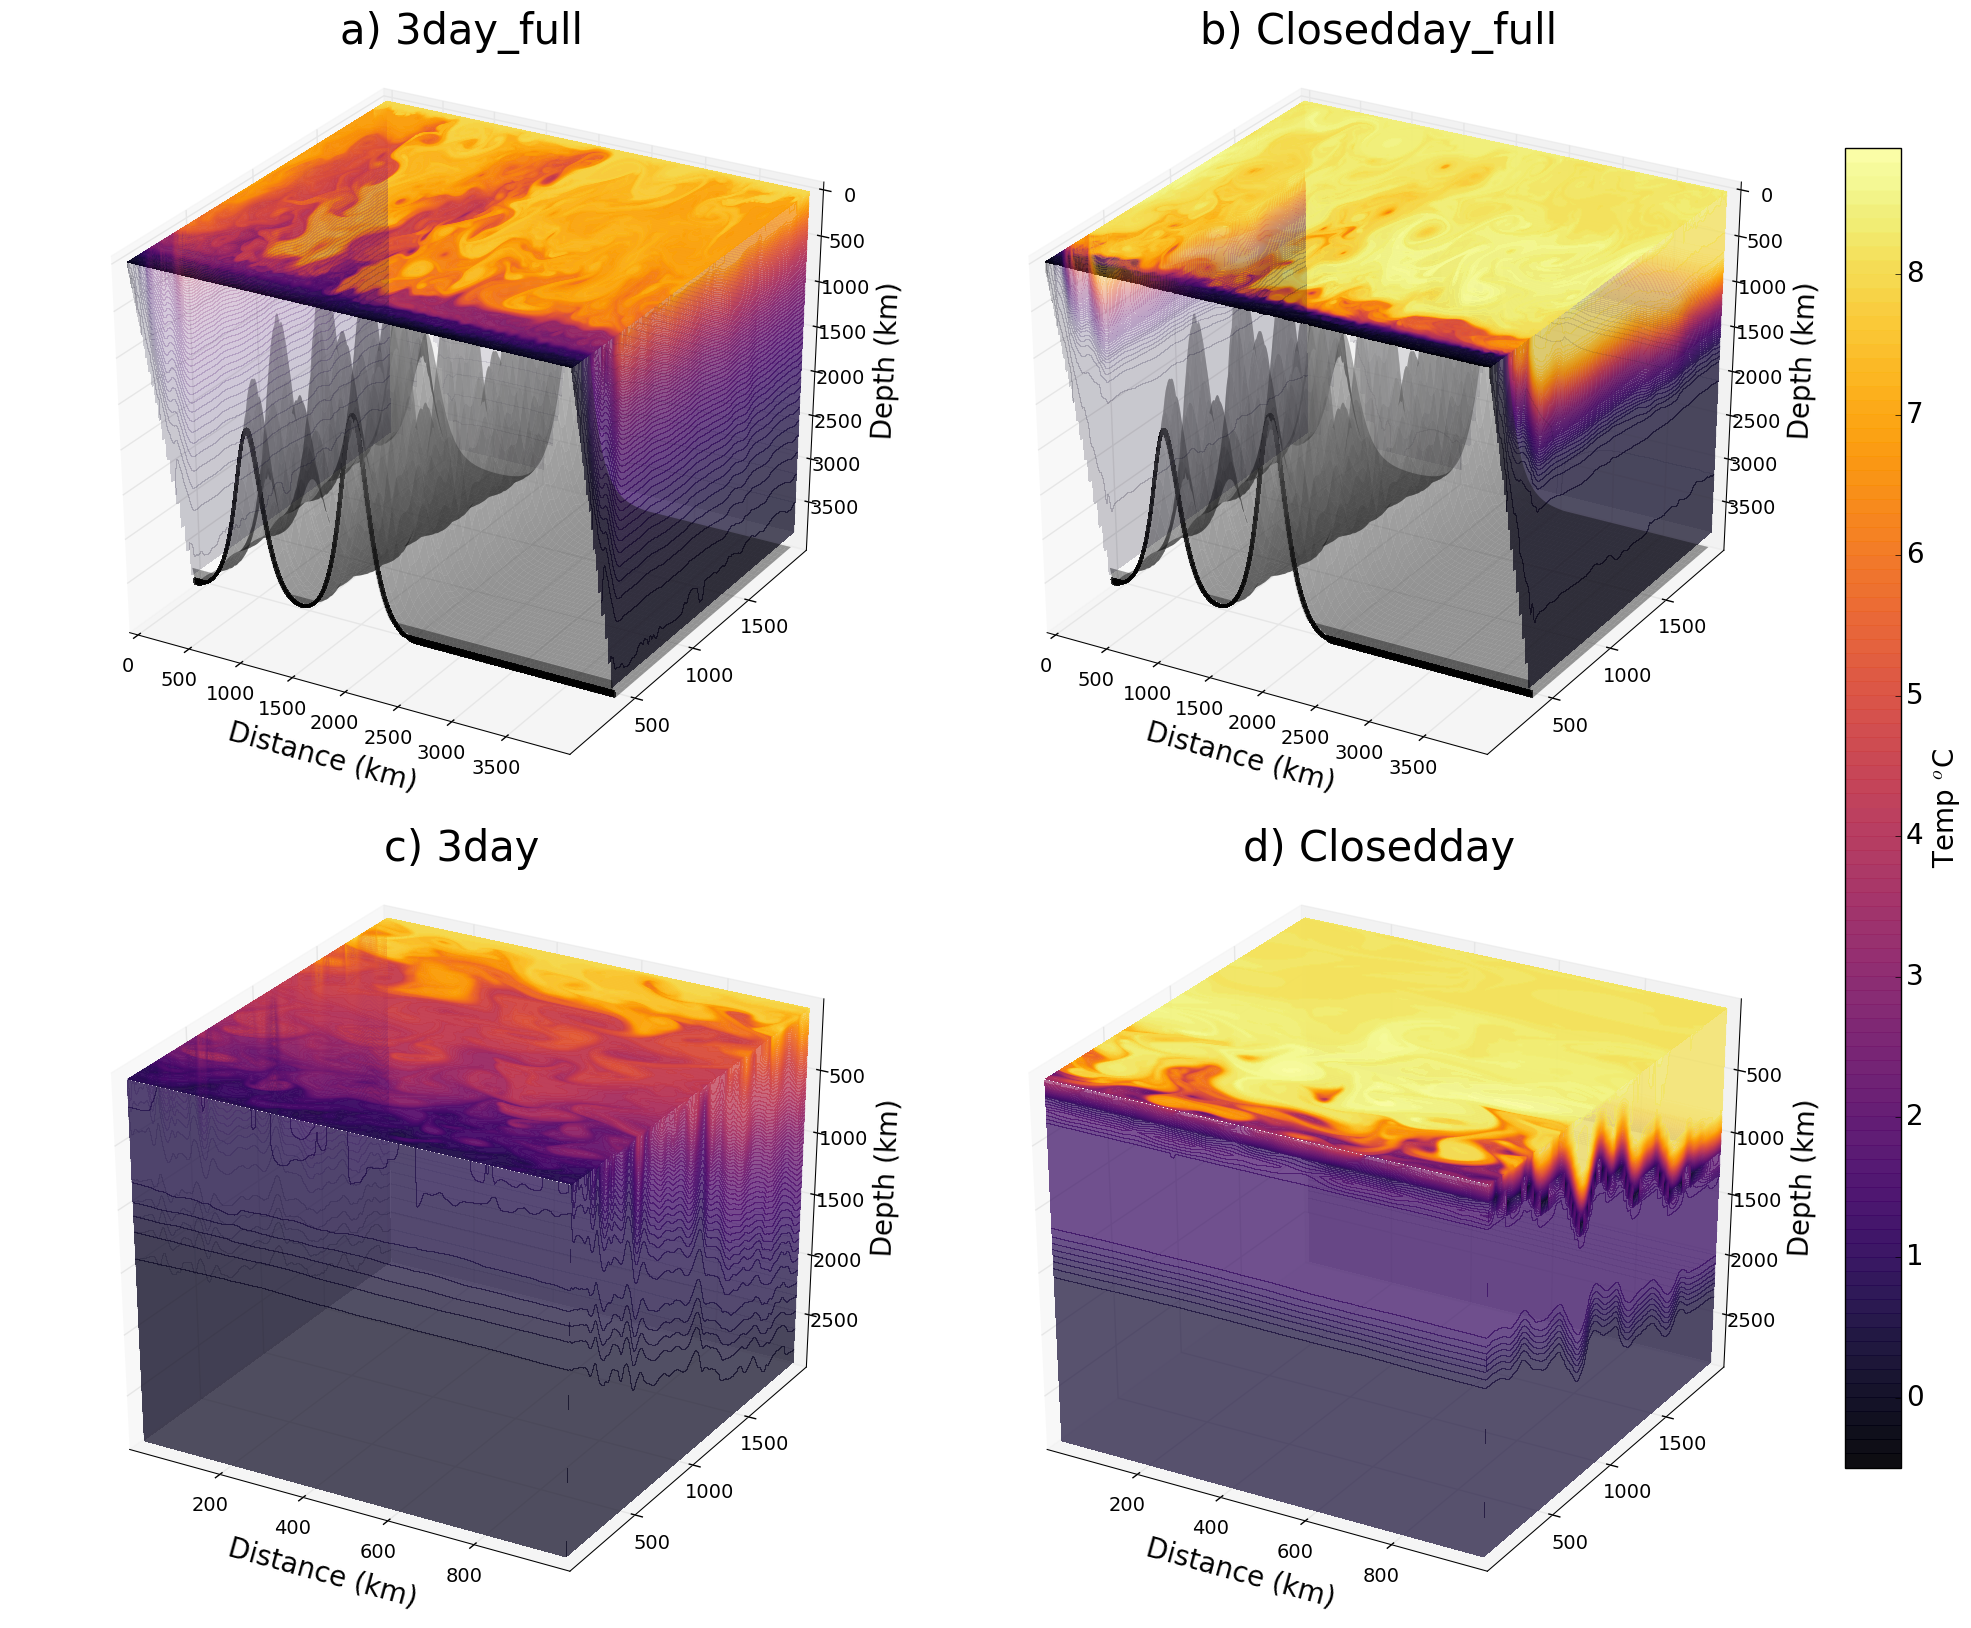

In [34]:
plt.clf
fig = plt.figure(figsize=(18.5, 16.5))
Q2_levs = (np.arange(-0, 9, .5))
Qticks =(np.arange(-0, 9, 1))
for i in range(len(Runs)):

    fname = x+'/'+str(tau[Runs[i]])+'/'
    c = utils.ChannelSetup(output_dir=str(fname))
    ax = fig.add_subplot(2, 2, i+1,projection='3d')
    Q2_levs = (np.arange(-.5, 9, .1))
    
    X = c.xc/1000
    Y = c.yc/1000
    Z = c.zc
    Xz, Yz = np.meshgrid(X, Y)
    Xx, Zx = np.meshgrid(X, Z)
    Yx, Zy = np.meshgrid(Y, Z)
    
    varone=c.mnc_t('Tav.nc','THETA')
    if varone.shape==4:
        varone=varone[0,:,:,:]
    varone[c.HFacC==0]=np.nan
    if i==3:
        varone[varone>2]= varone[varone>2]-2
        #Q2_levs = (np.arange(.0, 11, .05))
    #    tRef = [7.95797596, 7.81253554, 7.50931741, 6.93595077, 6.23538398,
    #            5.60148493, 5.02790935, 4.5089167 , 4.03931274, 3.6143975 ,
    #            3.22991829, 2.88202712, 2.56724216, 2.28241296, 2.02468884,
    #            1.79149041, 1.58048375, 1.38955702, 1.21679938, 1.0604818 ,
    #            0.9190398 , 0.79105779, 0.67525488, 0.57047207, 0.47566066,
    #            0.38987176, 0.31224674, 0.24200873, 0.14898305, 0.04478574]
    #    varone = np.apply_along_axis(np.divide, 0, varone, 4-np.sum(tRef*c.dzf)/-c.zc[-1])
    Z=varone[:,:,:]

    cset = [[],[],[],[]]
    if i>=2:
        cset = [[],[],[],[],[]]
    # Evaluate an existing colormap from 0.5 (midpoint) to 1 (upper end)
    cmap = plt.get_cmap('Greys')
    colors = cmap(np.linspace(0.5, 1, cmap.N // 2))

    # Create a new colormap from those colors
    cmap2 = LinearSegmentedColormap.from_list('Upper Half', colors)
    
    # zface
    cset[0] = ax.contourf(Xz, Yz, Z[0,:,:], zdir='z', offset=0,
                          levels=Q2_levs,cmap='inferno',alpha=.95,extend3d='both')
    if i==0:
        csetall = cset[0]
    if i<3:
        # now, for the x-constant face, assign the contour to the x-plot-variable:
        cset[1] = ax.contourf(Z[:,:,0], Yx, -Zy, zdir='x', offset=0,linewidth=0,
                              levels=Q2_levs,cmap='inferno',alpha=0.2,rstride=1, cstride=1)
    
    # now, for the x-constant face, assign the contour to the x-plot-variable:
    cset[2] = ax.contourf(Z[:,:,-1], Yx, -Zy, zdir='x', offset=(c.xc/1000)[-1],
                          levels=Q2_levs,cmap='inferno',alpha=0.7,rstride=1, cstride=1)
    
    # now, for the y-constant face, assign the contour to the y-plot-variable:
    cset[3] = ax.contourf(Xx, Z[:,-2,:], -Zx, zdir='y', offset=(c.yc/1000)[-1],
                          levels=Q2_levs,cmap='inferno',alpha=0.1,rstride=1, cstride=1)
    if i<2:
        
        # Topography
        Topo = ax.plot_surface(Xz[75:-5,:].T, Yz[75:-5,:].T, c.Depth[75:-5,:].T, rstride=8, cstride=8, cmap=cmap2,
                           linewidth=0, antialiased=True, alpha=0.4)
        Topo2 = ax.plot_surface(Xz[78:80,:].T, Yz[78:80,:].T, c.Depth[78:80,:].T, rstride=4, cstride=4, cmap=cmap2,
                           linewidth=2, antialiased=False, alpha=0.8)
    if i>=2:
        cset[4] = ax.contourf(Xx, Z[:,1,:], -Zx, zdir='y', offset=1,
                          levels=Q2_levs,cmap='inferno',alpha=0.7,rstride=1, cstride=1)
    # likewise, for the y-constant face, assign the contour to the y-plot-variable:
    #cset[2] = ax.contourf(Xx, Z[:,0,:], -Zx, zdir='y', offset=0,
    #                      levels=Q2_levs,cmap='jet')

    # setting 3D-axis-limits:    
    #ax.set_xlim3d(0,800)
    #ax.set_ylim3d(0,400)
    #ax.set_zlim3d(4000,0)
    
    ax.invert_zaxis()
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'\n', fontsize=30)
    ax.set_xlabel('\n Distance (km)', fontsize=20)
    ax.set_zlabel('\n Depth (km)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(csetall, cax=cax, ticks=Qticks)
cbar.ax.set_ylabel('Temp $^o$C', fontsize=20)
cbar.ax.tick_params(labelsize=20)



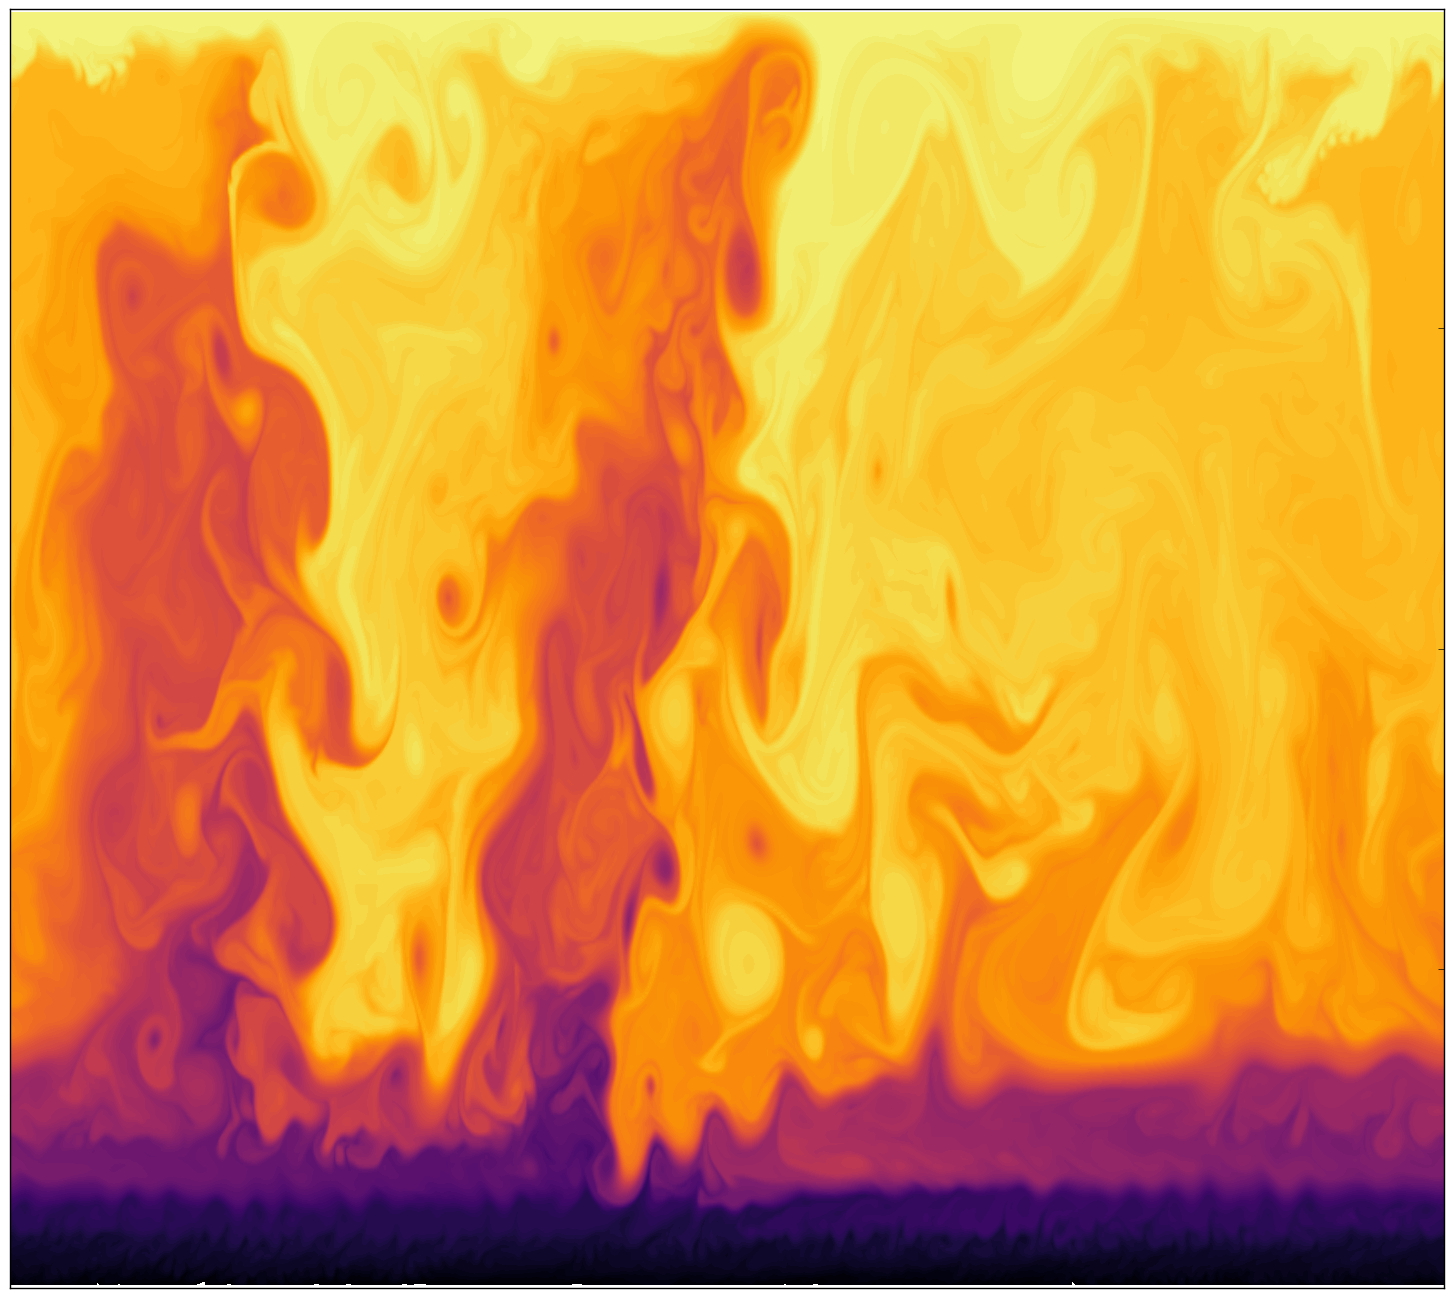

In [43]:
plt.clf
fig = plt.figure(figsize=(18.5, 16.5))
Q2_levs = (np.arange(-0, 9, .5))
Qticks =(np.arange(-0, 9, 1))
for i in range(len(Runs)):
    i = 0
    fname = x+'/'+str(tau[Runs[i]])+'/'
    c = utils.ChannelSetup(output_dir=str(fname))
 
    Q2_levs = (np.arange(-.3, 8.3, .1))
    
    X = c.xc/1000
    Y = c.yc/1000
    Z = c.zc
 
    varone=c.mnc_t('Tav.nc','THETA')
    if varone.shape==4:
        varone=varone[0,:,:,:]
    varone[c.HFacC==0]=np.nan
   
    Z=varone[:,:,:]



    # zface
    q = plt.contourf(X, Y, Z[0,:,:], zdir='z', 
                          levels=Q2_levs,cmap='inferno')
    
    plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off', left = 'off', labelleft='off') # labels along the bottom edge are off




Heat transport

In [11]:
# Some parameters
Full = 'Extremes'  # 9 Pannels isn't ideal for presentations N option give 4 plots
Qplot = 'Y'
Figletter = ['a) ','b) ','c) ','d) ','e)','f)','g)','h)','j)']
# Path root
x = '/noc/msm/scratch/students/hb1g13/Mobilis/'
# Now Make file structure
tau = ['3daynokpp', 'Closeddaynokpp', 'Full/3', 'Full/Closed']
check = 0
runs = []
for i in range(len(tau)):
    flist = x+'/'+str(tau[i])+'/Tav.nc'
    if not os.path.exists(flist):
        print ' WARNING: '+flist+' does not exist! (skipping this tau...)'
        check += 0
    else:
        check += 1
        runs.append(i)
Runs=np.array(runs)

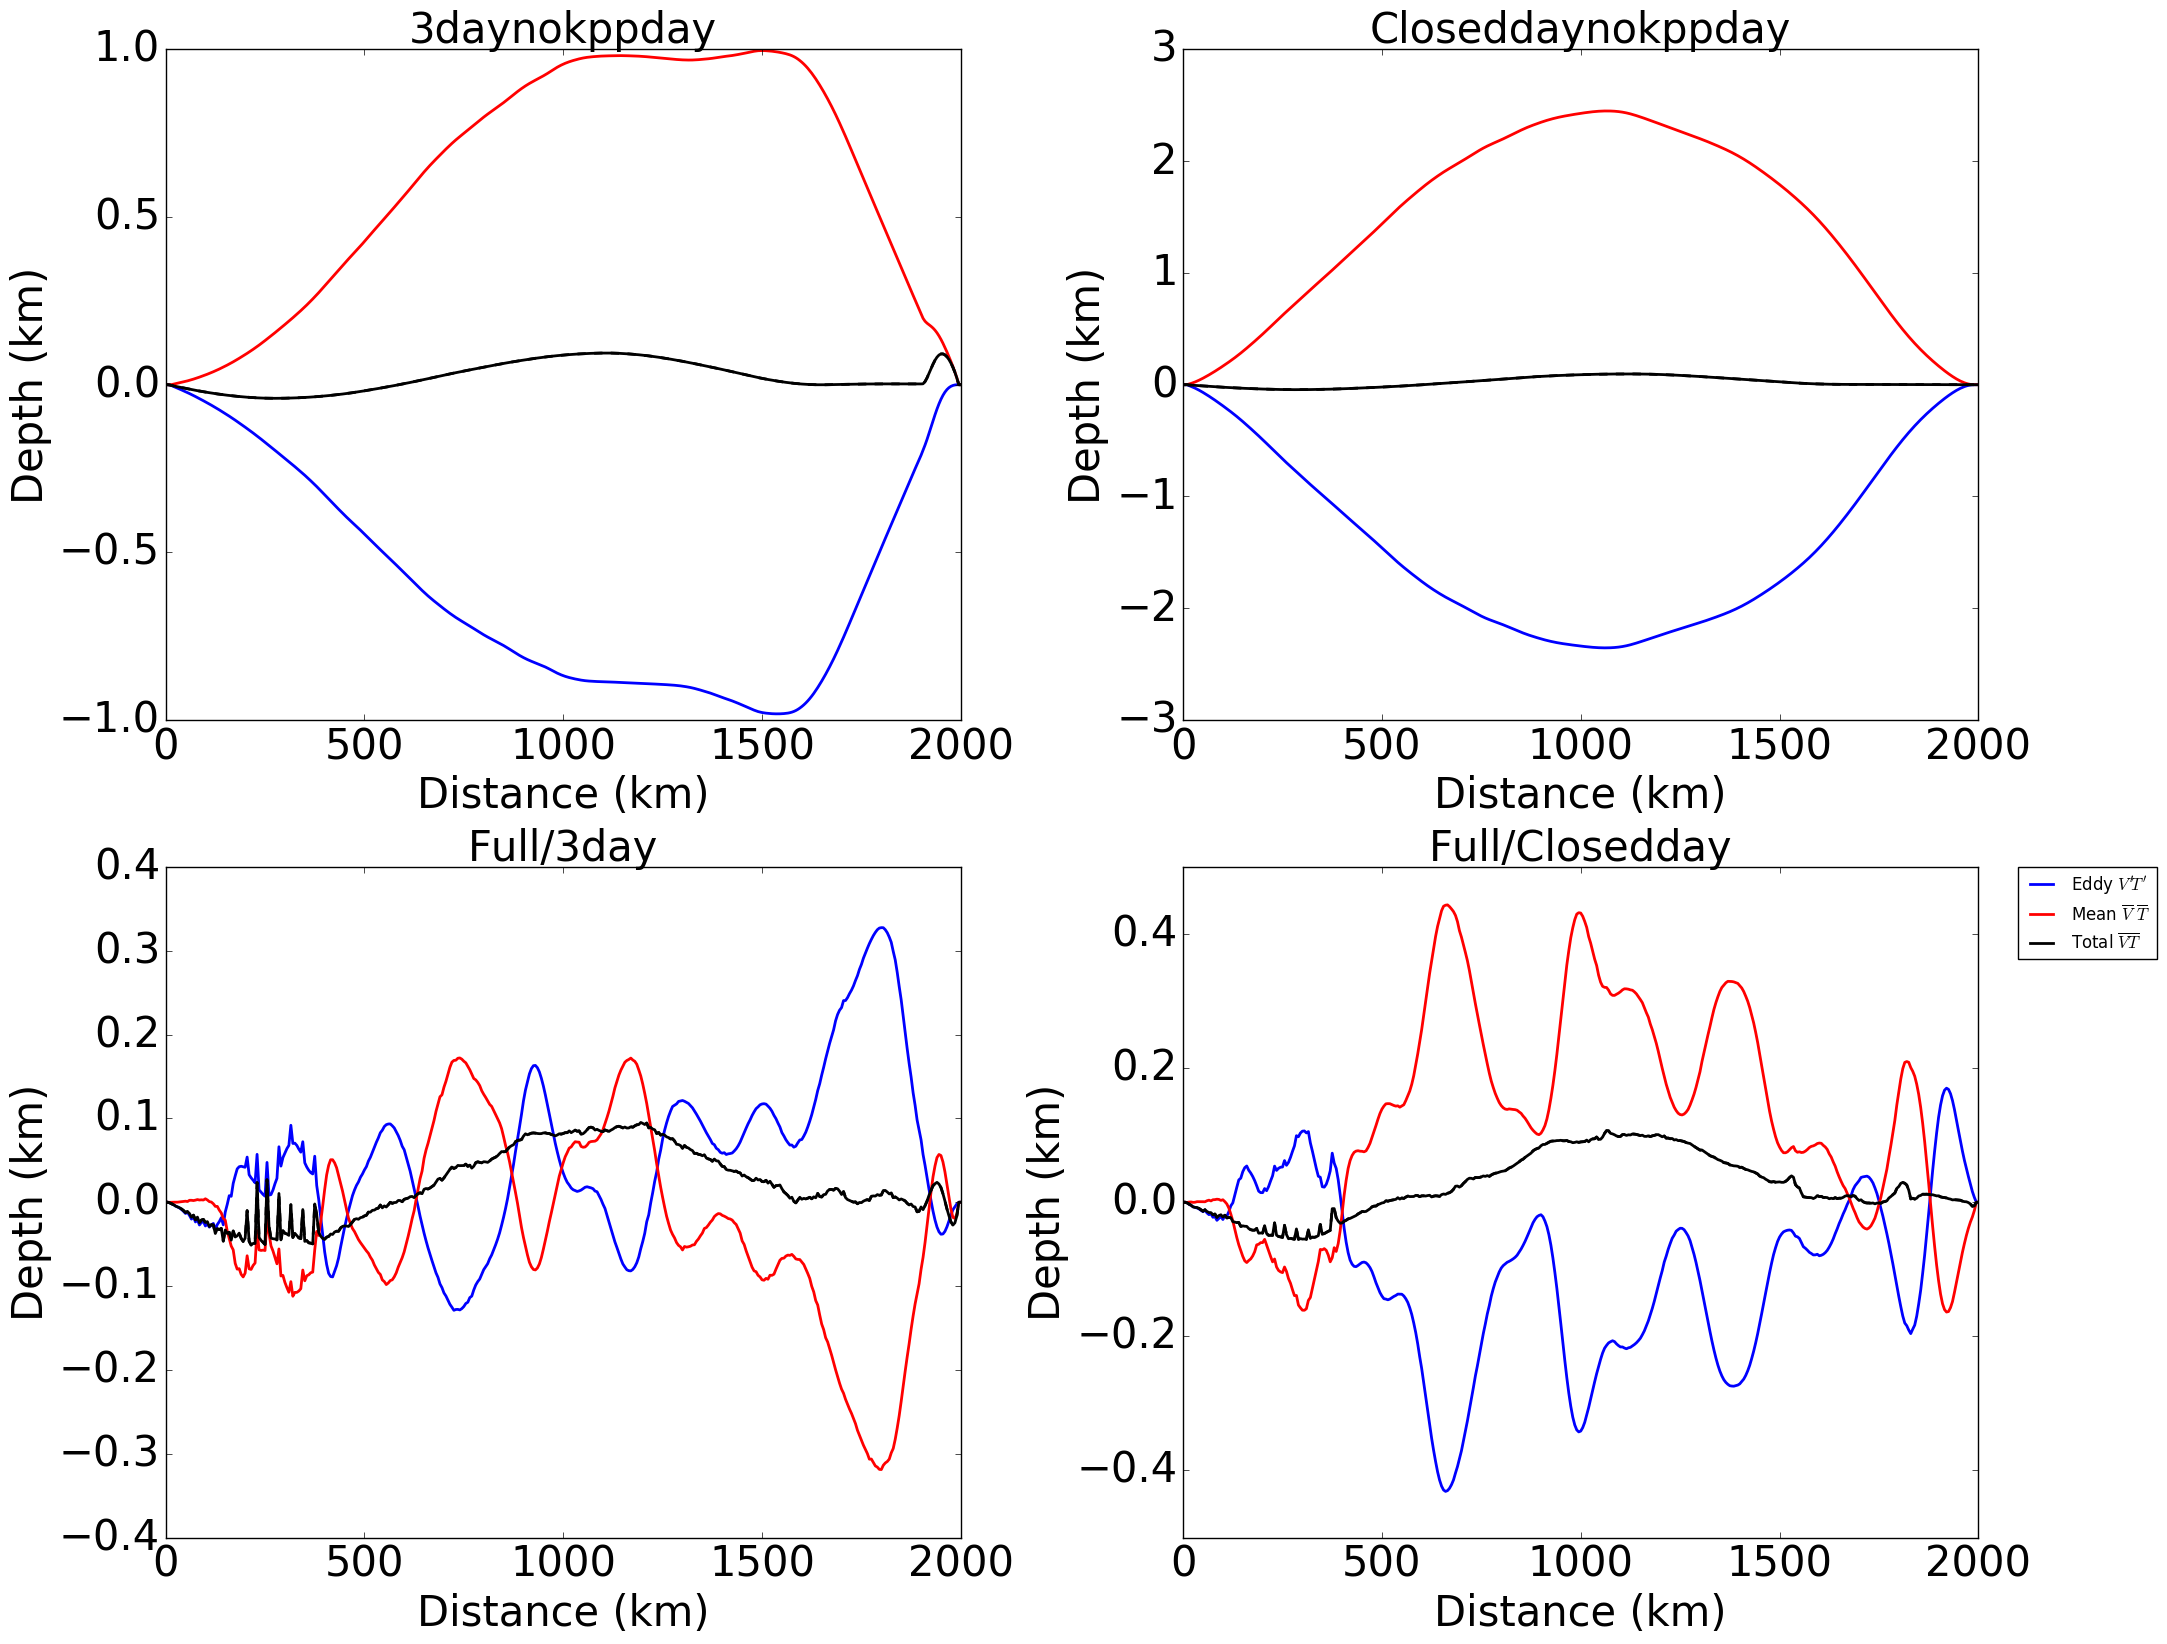

In [18]:
fig = plt.figure(figsize=(20.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    RAC = c.rac[0,0]*np.ones((c.Ny+1,c.Nx))
    CellVolv = RAC*tile(c.dzf,(c.Nx,c.Ny+1,1)).T
    CellVolw = c.rac*tile(c.dzf,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar                                                   
    # put everything on the C Grid                                                         
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    npad = ((0, 1), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    VTbar = (V*Tv)
    WTbar = (W*Tw)
    VpTp = ((VT - VTbar)*CellVolv).mean(axis=2)
    WpTp = (WT - WTbar).mean(axis=2)
    VT = ((VT)*CellVolv).mean(axis=2)
    WT = (WT).mean(axis=2)
    VTbar = ((VTbar)*CellVolv).mean(axis=2)
    WTbar = WTbar.mean(axis=2)
    MeanHF=1030*3985*(np.sum(VTbar,axis=0))/10**15
    EddyHF=1030*3985*(np.sum(VpTp,axis=0))/10**15
    TotalHF=1030*3985*(np.sum(VT,axis=0))/10**15
    THF=MeanHF+EddyHF
    ax = fig.add_subplot(2, 2, i+1)
    E,=ax.plot(c.yg/1000,EddyHF,linewidth=2)
    M,=ax.plot(c.yg/1000,MeanHF,'r',linewidth=2)
    T,=ax.plot(c.yg/1000,TotalHF,'k',linewidth=2)
    MEp,=ax.plot(c.yg/1000,THF,'--k',linewidth=2)
    (-3,3)
    ax.set_title(str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(tau[Runs[i]]), fontsize=30)
    ax.set_ylabel("Heat Flux (PW)")
    ax.set_xlabel("Meridional Distance (km)")
    ax.set_title(str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
lgd=legend([E,M,T],["Eddy $V'T'$","Mean $\overline{V}\,\,\overline{T}$",
                    "Total $\overline{VT}$"],bbox_to_anchor=(1.05, 1),loc=2, borderaxespad=0.)

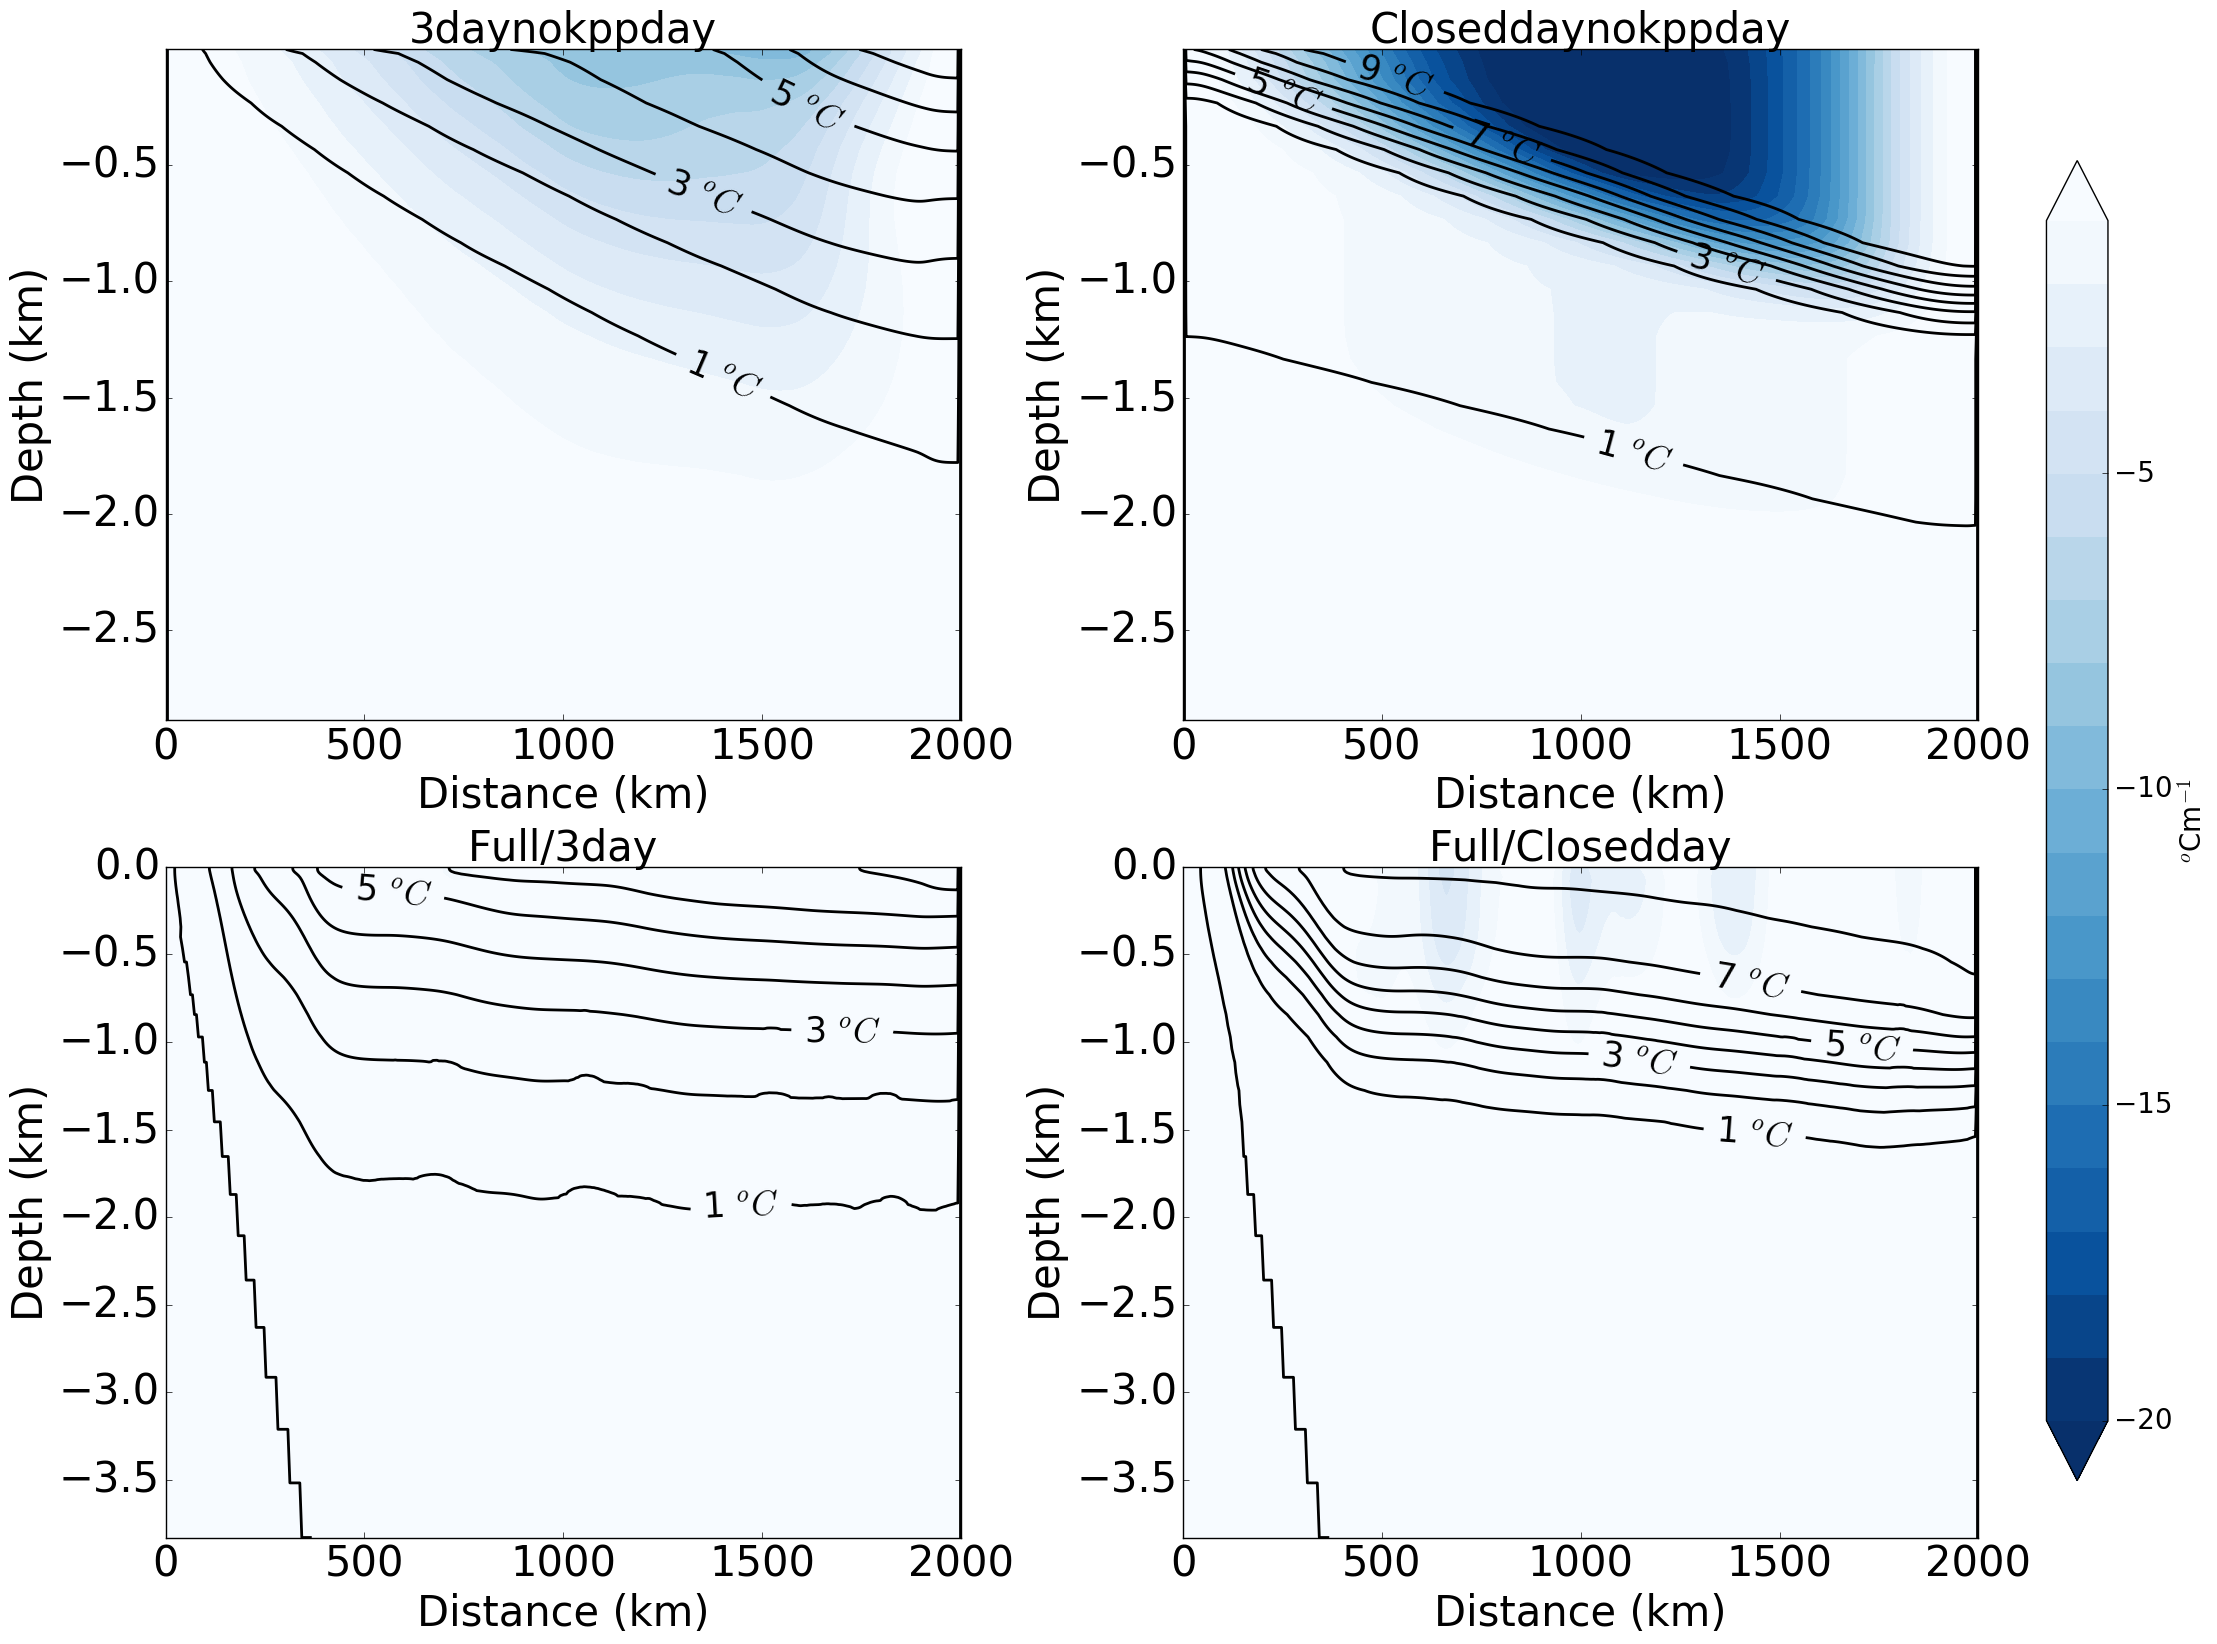

In [58]:
fig = plt.figure(figsize=(20.5, 16.5))
Q_levs = (arange(-20,0,1))
Qticks = (arange(-20,0,5))
Q2_levs = (np.arange(-1, 10, 1.))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    RAC = c.rac[0,0]*np.ones((c.Ny+1,c.Nx))
    CellVolv = tile(c.dzf,(c.Nx,c.Ny+1,1)).T
    CellVolw = c.rac*tile(c.dzf,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar                                                   
    # put everything on the C Grid                                                         
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tzone = (c.mnc('Tav.nc','THETA')).mean(axis=2)
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    npad = ((0, 1), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    VTbar = (V*Tv)
    WTbar = (W*Tw)
    VpTp = np.cumsum(((VT - VTbar)*CellVolv).mean(axis=2)[::-1],axis=0)[::-1]
    WpTp = (WT - WTbar).mean(axis=2)
    VT = ((VT)*CellVolv).mean(axis=2)
    WT = (WT).mean(axis=2)
    VTbar = ((VTbar)).mean(axis=2)
    WTbar = WTbar.mean(axis=2)
    ax = fig.add_subplot(2, 2, i+1)
    p = ax.contourf(c.yg/1000, c.zc/1000, VpTp , Q_levs, cmap=plt.cm.Blues_r, extend='both')
    q = ax.contour(c.yc/1000, c.zc/1000, Tzone, Q2_levs, colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=25)
    ax.set_title(str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(tau[Runs[i]]), fontsize=30)
    ax.set_ylabel("Heat Flux (PW)")
    ax.set_xlabel("Meridional Distance (km)")
    ax.set_title(str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax, ticks=Qticks)
cbar.ax.set_ylabel('$^o$Cm$^{-1}$', fontsize=20)
cbar.ax.tick_params(labelsize=20)